In [8]:
# ==================== Testing traj-avg Observables ====================
# This notebook tests the trajectory-averaged observables from multiple G(t) histories.
# Imports & hot-reload

import os, importlib, numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

import classA_U1FGTN as mod
importlib.reload(mod)
from classA_U1FGTN import classA_U1FGTN

In [2]:
# parameters (DW = False)
Nx, Ny   = 16, 16
cycles   = 20
samples  = 100
nshell   = None               # None for untruncated
DW       = True
m_DW = classA_U1FGTN(Nx, Ny, DW=DW)

# parameters (DW = False)
Nx, Ny   = 16, 16
cycles   = 20
samples  = 1
nshell   = None               # None for untruncated
DW       = False
m = classA_U1FGTN(Nx, Ny, DW=DW)


DWs at x=(4, 11)
------------------------- classA_U1FGTN Initialized -------------------------
------------------------- classA_U1FGTN Initialized -------------------------


In [9]:
def unflatten_to_G6(Gfull, Nx, Ny, top=True):
    """
    Take full covariance matrix Gfull of shape (Ntot, Ntot),
    with Ntot = 4*Nx*Ny, and reshape to structured
    G6 of shape (Nx, Ny, 2, Nx, Ny, 2).
    """
    if top:
        Nlayer = 2 * Nx * Ny
        assert Gfull.shape == (Nlayer, Nlayer), f"Expected ({Nlayer},{Nlayer}), got {Gfull.shape}"

    # First reshape as (2,Nx,Ny, 2,Nx,Ny) with Fortran order
    G6m = Gfull.reshape((2, Nx, Ny, 2, Nx, Ny), order='F')

    # Permute axes: (μ, x, y, ν, x', y') -> (x, y, μ, x', y', ν)
    G6 = np.transpose(G6m, (1, 2, 0, 4, 5, 3))

    return G6

def _flatten_full_matrix(G6):
    """
    Flatten G(x,y,μ; x',y',ν) -> G_flat with index
        i = μ + 2*x + 2*Nx*y   (Fortran order on (μ,x,y)).
    """
    G6 = np.asarray(G6, dtype=np.complex128)
    Nx, Ny, s1, Nx2, Ny2, s2 = G6.shape
    if not ((s1, s2) == (2, 2) and (Nx, Ny) == (Nx2, Ny2)):
        raise ValueError(f"G must have shape (Nx, Ny, 2, Nx, Ny, 2); got {G6.shape}")
    # (μ, x, y ; ν, x', y')
    G6m = np.transpose(G6, (2, 0, 1, 5, 3, 4))         # (2,Nx,Ny, 2,Nx,Ny)
    return G6m.reshape(2*Nx*Ny, 2*Nx*Ny, order='F')

In [ ]:
data_DW = np.load('cache/G_history_samples/N16x16_C20_S500_nshNone_DW1_init-default_n_a0.5_markov_circuit_alpha_triv=30.npz', allow_pickle=True)
Nlayer = 2*Nx*Ny
G_DW = unflatten_to_G6(data_DW[data_DW.files[0]].mean(axis=0)[-1,:Nlayer,:Nlayer], Nx, Ny) # G_DW will denote the last time step of the traj-averaged complex covariance matrix with DWs


(16, 16, 2, 16, 16, 2) complex128


In [5]:
print(G_DW.shape, G_DW.dtype)

(16, 16, 2, 16, 16, 2) complex128


In [23]:
Nlayer = 2*Nx*Ny
data_new = np.load('cache/G_history_samples/N16x16_C20_S100_nshNone_DW1_init-default_fromcache-s0-t19.npz', allow_pickle=True)
G_new = unflatten_to_G6(data_new[data_new.files[0]].mean(axis=0)[-1,:Nlayer,:Nlayer], Nx, Ny)
print(G_new.shape, G_new.dtype) # G will denote the steady-state of the complex covariance with DWs

(16, 16, 2, 16, 16, 2) complex128


In [24]:
Nlayer = 2*Nx*Ny
data_new_new = np.load('cache/G_history_samples/N16x16_C40_S100_nshNone_DW1_init-default_fromcache-rerun-s0-t19.npz', allow_pickle=True)
G_new_new = unflatten_to_G6(data_new_new[data_new_new.files[0]].mean(axis=0)[-1,:Nlayer,:Nlayer], Nx, Ny)
print(G_new_new.shape, G_new_new.dtype) # G will denote the steady-state of the complex covariance with DWs

(16, 16, 2, 16, 16, 2) complex128


In [17]:


def _fft_y_blocks_from_flat(G6, norm='ortho', hermitize=True):
    """
    Go to k_y basis via unitary FFT on y and IFFT on y', then flatten and
    extract Ny contiguous blocks of size (2*Nx)x(2*Nx):

        block j := G_flat[2*j*Nx : 2*(j+1)*Nx, 2*j*Nx : 2*(j+1)*Nx]

    Returns:
        ky_vals : length-Ny array of 2π-periodic k_y values (FFT order)
        blocks  : list of length Ny, each (2*Nx, 2*Nx) complex Hermitian block
    """
    G6 = np.asarray(G6, dtype=np.complex128)
    Nx, Ny, s1, Nx2, Ny2, s2 = G6.shape
    if not ((s1, s2) == (2, 2) and (Nx, Ny) == (Nx2, Ny2)):
        raise ValueError(f"G must have shape (Nx, Ny, 2, Nx, Ny, 2); got {G6.shape}")

    # Unitarty transform on y/y' to k_y/k'_y
    Gk6 = np.fft.fft(G6,  axis=1, norm=norm)   # y  → k  (bra)
    Gk6 = np.fft.ifft(Gk6, axis=4, norm=norm)  # y' → k' (ket)

    # Flatten with i = μ + 2*x + 2*Nx*y; in k_y basis this becomes block-diagonal in y
    G_flat = _flatten_full_matrix(Gk6)
    if hermitize:
        G_flat = 0.5 * (G_flat + G_flat.conj().T)

    blocks = []
    for j in range(Ny):
        lo = 2 * j * Nx
        hi = 2 * (j + 1) * Nx
        Bj = G_flat[lo:hi, lo:hi]
        if hermitize:
            Bj = 0.5 * (Bj + Bj.conj().T)
        blocks.append(Bj)

    ky_vals = 2*np.pi * np.fft.fftfreq(Ny, d=1.0)  # radians/site
    return ky_vals, blocks

def plot_ky_spectrum(G6, norm='ortho', hermitize=True, ax=None, marker='.', ms=3):
    """
    Using the 'contiguous 2*Nx blocks after flattening' rule in k_y basis:
      1) FFT on y (bra) and IFFT on y' (ket)
      2) Flatten and slice blocks as:
           block j = G_flat[2*j*Nx:2*(j+1)*Nx, 2*j*Nx:2*(j+1)*Nx]
      3) Diagonalize each block and plot ordered eigenvalues vs k_y.

    Returns:
        ky_vals (Ny,), evals (Ny, 2*Nx), ax
    """
    ky_vals, blocks = _fft_y_blocks_from_flat(G6, norm=norm, hermitize=hermitize)

    # shapes
    G6 = np.asarray(G6)
    Nx, Ny = int(G6.shape[0]), int(G6.shape[1])

    evals = np.empty((Ny, 2*Nx), dtype=float)
    for j, B in enumerate(blocks):
        w = np.linalg.eigvalsh(B)   # Hermitian
        evals[j, :] = np.sort(np.real_if_close(w))

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4.2))
    else:
        fig = ax.figure

    for band in evals.T:
        ax.plot(ky_vals, band, marker, ms=ms, lw=0)

    ax.set_xlabel(r"$k_y$")
    ax.set_ylabel("eigenvalue")
    ax.set_title(r"Spectrum of $G(k_y)$ blocks (contiguous $2N_x$ rule)")
    ax.grid(True, alpha=0.3)
    return ky_vals, evals, ax

In [12]:
def check_y_translation_invariance(
    G,
    *,
    tol_shift=1e-10,
    tol_offdiag=1e-10,
    hermitize=True
):
    """
    Check y-translation invariance and the block structure after the y/y' unitary FFT.

    Returns a dict with:
      - shape_ok
      - Ny
      - shift_max_abs_diff, shift_pass
      - offdiag_ratio, offdiag_pass
    """
    G = np.asarray(G)
    ok = (G.ndim == 6)
    if not ok:
        return {"shape_ok": False}

    Nx, Ny, s1, Nx2, Ny2, s2 = G.shape
    shape_ok = (s1, s2) == (2, 2) and (Nx, Ny) == (Nx2, Ny2)
    if not shape_ok:
        return {"shape_ok": False}

    # (optional) tiny hermitization for numerical stability
    if hermitize:
        G = 0.5 * (G + np.transpose(G.conj(), (3,4,5,0,1,2)))

    # ---------------- 1) shift invariance along y ----------------
    # Check G(x,y,μ; x',y',ν) == G(x,y+1,μ; x',y'+1,ν)
    Gy   = G
    Gy_p = np.roll(np.roll(G, shift=+1, axis=1), shift=+1, axis=4)
    shift_max_abs_diff = float(np.max(np.abs(Gy - Gy_p)))
    shift_pass = (shift_max_abs_diff <= tol_shift)

    # ---------------- 2) ky block off-diagonal check ----------------
    # Unitary: FFT on y (bra), IFFT on y' (ket)
    Gk = np.fft.fft(G,  axis=1, norm='ortho')
    Gk = np.fft.ifft(Gk, axis=4, norm='ortho')

    diag_mask = np.eye(Ny, dtype=bool)
    off_mask = ~diag_mask

    # Frobenius norms aggregated:
    block_norms = np.sum(np.abs(Gk)**2, axis=(0, 2, 3, 5))
    den = float(block_norms.sum())
    num = float(block_norms[off_mask].sum())
    offdiag_ratio = 0.0 if den == 0 else float(num / den)
    offdiag_pass  = (offdiag_ratio <= tol_offdiag)

    report = {
        "shape_ok": True,
        "Ny": Ny,
        "shift_max_abs_diff": shift_max_abs_diff,
        "shift_pass": bool(shift_pass),
        "offdiag_ratio": offdiag_ratio,
        "offdiag_pass": bool(offdiag_pass),
    }
    return report



In [8]:
def check_y_translation_invariance_fixed_x(
    G,
    x0,
    *,
    x0_ket=None,
    tol_shift=1e-10,
    tol_offdiag=1e-10,
    hermitize=True,
):
    """
    Check y-translation invariance and ky block structure for a fixed x slice.

    Parameters
    ----------
    G : array_like, shape (Nx, Ny, 2, Nx, Ny, 2)
        Complex covariance tensor on the lattice.
    x0 : int
        Bra x-index to inspect.
    x0_ket : int or None, optional
        Ket x-index to inspect (defaults to x0).
    tol_shift, tol_offdiag : float
        Thresholds for the shift and off-diagonal tests.
    hermitize : bool
        Whether to symmetrize G for numerical stability.

    Returns
    -------
    dict
        Keys:
          - shape_ok
          - Nx, Ny
          - x0, x0_ket
          - shift_max_abs_diff, shift_pass
          - offdiag_ratio, offdiag_pass
    """
    G = np.asarray(G)
    if G.ndim != 6:
        raise ValueError(f"Expected 6D array, got {G.shape}")

    Nx, Ny, s1, Nx2, Ny2, s2 = G.shape
    shape_ok = (s1, s2) == (2, 2) and (Nx, Ny) == (Nx2, Ny2)
    if not shape_ok:
        return {"shape_ok": False}

    if hermitize:
        G = 0.5 * (G + np.transpose(G.conj(), (3, 4, 5, 0, 1, 2)))

    x0_ket = x0 if x0_ket is None else x0_ket
    if not (0 <= x0 < Nx and 0 <= x0_ket < Nx):
        raise IndexError(f"x0={x0}, x0_ket={x0_ket} out of range 0..{Nx-1}")

    # Extract the fixed-x slice: G(x0, y, μ; x0_ket, y', ν)
    G_slice = G[x0, :, :, x0_ket, :, :]  # shape (Ny, 2, Ny, 2)

    # --- 1) shift invariance along y for this slice ---
    Gs = G_slice
    Gs_p = np.roll(np.roll(Gs, shift=+1, axis=0), shift=+1, axis=2)
    shift_max_abs_diff = float(np.max(np.abs(Gs - Gs_p)))
    shift_pass = shift_max_abs_diff <= tol_shift

    # --- 2) ky block off-diagonal check for this slice ---
    Gk = np.fft.fft(Gs, axis=0, norm="ortho")
    Gk = np.fft.ifft(Gk, axis=2, norm="ortho")

    block_norms = np.sum(np.abs(Gk) ** 2, axis=(1, 3))  # shape (Ny, Ny)
    den = float(block_norms.sum())
    num = float(block_norms[np.eye(Ny, dtype=bool) == False].sum())
    offdiag_ratio = 0.0 if den == 0 else num / den
    offdiag_pass = offdiag_ratio <= tol_offdiag

    return {
        "shape_ok": True,
        "Nx": Nx,
        "Ny": Ny,
        "x0": int(x0),
        "x0_ket": int(x0_ket),
        "shift_max_abs_diff": shift_max_abs_diff,
        "shift_pass": bool(shift_pass),
        "offdiag_ratio": offdiag_ratio,
        "offdiag_pass": bool(offdiag_pass),
    }

In [9]:
rep_DW = check_y_translation_invariance(G_DW, hermitize=True)
print(rep_DW)


{'shape_ok': True, 'Ny': 16, 'shift_max_abs_diff': 0.11797708066074325, 'shift_pass': False, 'offdiag_ratio': 0.0006061317419348408, 'offdiag_pass': False}


In [29]:
x0_DW = m_DW.DW_loc[0]
rep_DW = check_y_translation_invariance_fixed_x(G_DW, x0 = x0_DW, hermitize=True)
print(rep_DW)

{'shape_ok': True, 'Nx': 16, 'Ny': 16, 'x0': 4, 'x0_ket': 4, 'shift_max_abs_diff': 0.15546235836942923, 'shift_pass': False, 'offdiag_ratio': 0.007115146288343273, 'offdiag_pass': False}


In [30]:
x0_bulk = 0
rep_DW = check_y_translation_invariance_fixed_x(G_DW, x0 = x0_bulk, hermitize=True)
print(rep_DW)

{'shape_ok': True, 'Nx': 16, 'Ny': 16, 'x0': 0, 'x0_ket': 0, 'shift_max_abs_diff': 0.00020193470076490793, 'shift_pass': False, 'offdiag_ratio': 1.32609008796734e-08, 'offdiag_pass': False}


In [31]:
rep_new = check_y_translation_invariance_with_spectrum(G_new, hermitize=True)
print(rep_new)

{'shape_ok': True, 'Ny': 16, 'shift_max_abs_diff': 0.12997568019964356, 'shift_pass': False, 'offdiag_ratio': 0.0016191323171695787, 'offdiag_pass': False}


In [32]:
x0_DW = m_DW.DW_loc[0]
rep_DW = check_y_translation_invariance_fixed_x(G_new, x0 = x0_DW, hermitize=True)
print(rep_DW)


{'shape_ok': True, 'Nx': 16, 'Ny': 16, 'x0': 4, 'x0_ket': 4, 'shift_max_abs_diff': 0.08086778199073996, 'shift_pass': False, 'offdiag_ratio': 0.006074705483838298, 'offdiag_pass': False}


In [33]:
x0_bulk = 0
rep_DW = check_y_translation_invariance_fixed_x(G_new, x0 = x0_bulk, hermitize=True)
print(rep_DW)

{'shape_ok': True, 'Nx': 16, 'Ny': 16, 'x0': 0, 'x0_ket': 0, 'shift_max_abs_diff': 0.0052106577170605295, 'shift_pass': False, 'offdiag_ratio': 2.198173046358092e-06, 'offdiag_pass': False}


In [34]:
rep_new_new = check_y_translation_invariance_with_spectrum(G_new_new, hermitize=True)
print(rep_new_new)

{'shape_ok': True, 'Ny': 16, 'shift_max_abs_diff': 0.1203674000786985, 'shift_pass': False, 'offdiag_ratio': 0.0015114453560686678, 'offdiag_pass': False}


In [35]:
x0_DW = m_DW.DW_loc[0]
rep_DW = check_y_translation_invariance_fixed_x(G_new_new, x0 = x0_DW, hermitize=True)
print(rep_DW)


{'shape_ok': True, 'Nx': 16, 'Ny': 16, 'x0': 4, 'x0_ket': 4, 'shift_max_abs_diff': 0.10087731686682033, 'shift_pass': False, 'offdiag_ratio': 0.007544697046983247, 'offdiag_pass': False}


In [36]:
x0_bulk = 0
rep_DW = check_y_translation_invariance_fixed_x(G_new_new, x0 = x0_bulk, hermitize=True)
print(rep_DW)

{'shape_ok': True, 'Nx': 16, 'Ny': 16, 'x0': 0, 'x0_ket': 0, 'shift_max_abs_diff': 0.007587443592655507, 'shift_pass': False, 'offdiag_ratio': 3.009413251889857e-06, 'offdiag_pass': False}


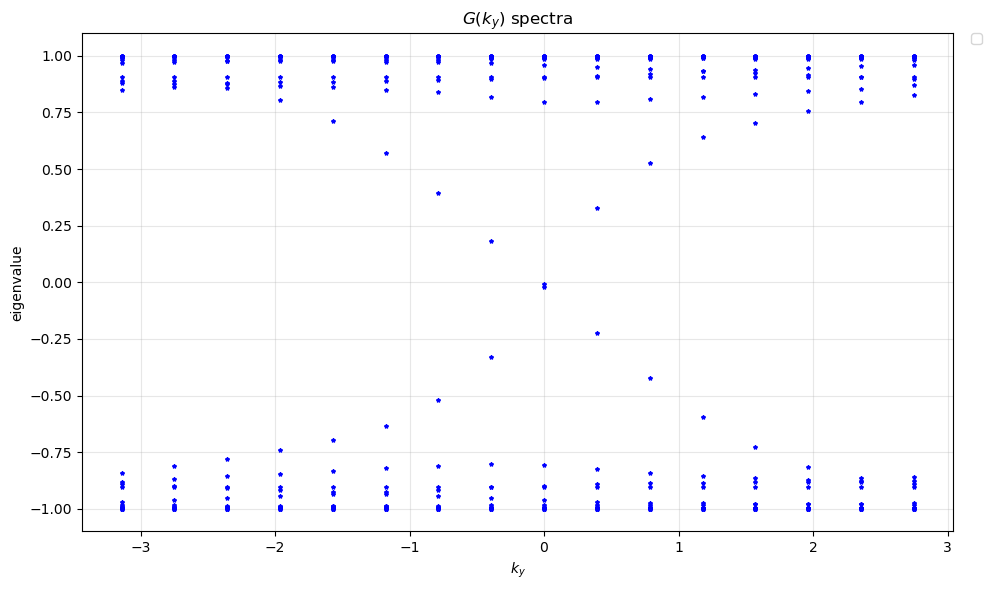

In [10]:

# --- Call the plotting function ---
fig, ax = plt.subplots(figsize=(10,6))

# Decoherence off: blue '*'
ky_off, evals, _ = plot_ky_spectrum(G_DW, ax=ax, marker='*', ms=3)
# recolor all lines orange
for line in ax.get_lines()[-evals.shape[1]:]:
    line.set_color('blue')

# De-duplicate legend entries and move outside axis
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(),
          loc='upper left', bbox_to_anchor=(1.02,1.0), borderaxespad=0)

ax.set_title("$G(k_y)$ spectra")
ax.set_yscale('linear')
plt.tight_layout()
plt.show()

In [8]:
# load DW=False data and traj-avge
G = np.load('cache/G_history_samples/N21x21_C20_S1_nsh5_DW0_init-default.npz', allow_pickle=True)['G_full']
print(G.shape, G.dtype)  # probably (S,T) object

(1, 20, 1764, 1764) complex128


(882, 882) complex128


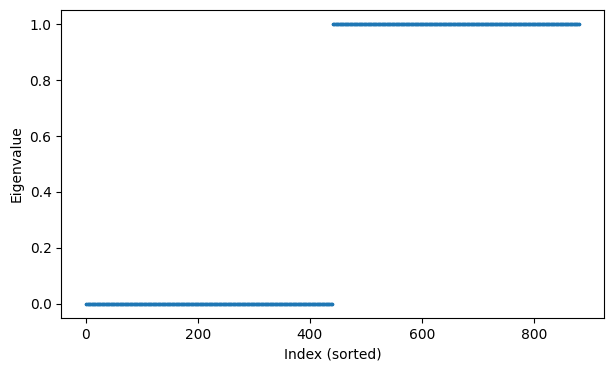

In [ ]:
Ntot = 4*Nx*Ny
Nlayer = Ntot//2
Gtt_last = G[0,-1,:Nlayer,:Nlayer]
print(Gtt_last.shape, Gtt_last.dtype)  
Gtt2pt = 0.5*(Gtt_last + np.eye(Gtt_last.shape[0]))
spec = np.linalg.eigvalsh(Gtt2pt)
plt.figure(figsize=(7,4))
plt.plot(np.sort(spec), '.', ms=3)
plt.xlabel("Index (sorted)")
plt.ylabel("Eigenvalue")
plt.show()


In [6]:
def unflatten_to_G6(Gfull, Nx, Ny, top=True):
    """
    Take full covariance matrix Gfull of shape (Ntot, Ntot),
    with Ntot = 4*Nx*Ny, and reshape to structured
    G6 of shape (Nx, Ny, 2, Nx, Ny, 2).
    """
    if top:
        Nlayer = 2 * Nx * Ny
        assert Gfull.shape == (Nlayer, Nlayer), f"Expected ({Nlayer},{Nlayer}), got {Gfull.shape}"

    # First reshape as (2,Nx,Ny, 2,Nx,Ny) with Fortran order
    G6m = Gfull.reshape((2, Nx, Ny, 2, Nx, Ny), order='F')

    # Permute axes: (μ, x, y, ν, x', y') -> (x, y, μ, x', y', ν)
    G6 = np.transpose(G6m, (1, 2, 0, 4, 5, 3))

    return G6

def square_correlation_function(G,Nx,Ny,x_max=None,y_max=None):
    '''
    Generates the square correlator from an input complex covariance G of shape (2*Nx*Ny, 2*Nx*Ny) (just top layer)
    The square correlator is defined as 
    
        C(x,y) = 1/(2Nx*Ny)\sum_{\mu,\mu', \mathbf{r}} <\hat{c}^\dagger_{\mu',\mathbf{r}}\hat{c}_{\mu,\mathbf{r}+(x,y)}>
    
    and will have shape (x_max, y_max)
    '''
    if x_max is None:
        x_max = Nx//2
    if y_max is None:
        y_max = Ny//2

    rx = np.arange(x_max)
    ry = np.arange(y_max)

    G2pt_flat = 0.5 * (G + np.eye(G.shape[0], dtype=G.dtype))
    G6 = unflatten_to_G6(G2pt_flat, Nx, Ny)  # (Nx,Ny,2,Nx,Ny,2)

    X, Y = np.meshgrid(np.arange(Nx), np.arange(Ny), indexing='ij')
    Xb, Yb = X[:, :, None, None], Y[:, :, None, None]
    Xp = (Xb + rx[None, None, :, None]) % Nx   # (Nx,Ny, R, 1)
    Yp = (Yb + ry[None, None, None, :]) % Ny   # (Nx,Ny, 1, R')

    # Broadcast gather: result shape (Nx,Ny, R, R', 2, 2)
    B = G6[Xb, Yb, :, Xp, Yp, :]

    # Sum over origins (0,1) and internal indices (4,5)
    C = np.sum(np.abs(B)**2, axis=(0, 1, 4, 5)) / (2.0 * Nx * Ny)  # shape (R, R')
    return C

C = square_correlation_function(Gtt_last,Nx,Ny)
plt.figure(figsize=(6,5))
plt.imshow(C.T, origin='lower', extent=(0,C.shape[0],0,C.shape[1]), aspect='auto')
plt.colorbar(label=r'$C(x,y)$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Square correlation function')
plt.show()

NameError: name 'Gtt_last' is not defined

(8,)


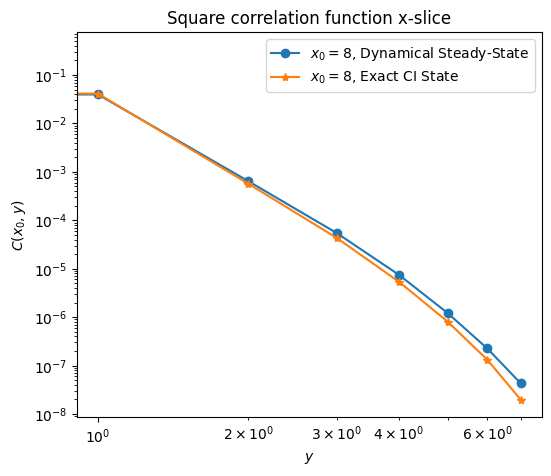

In [ ]:
# x_slice square correlation function
def squared_two_point_corr_xslice(G, Nx, Ny, x0=None, ry_max=None):
    '''Return |G|^2 along a fixed x-column for specified y displacements.'''
    if x0 is None:
        x0 = Nx // 2
        
    if ry_max is None:
        ry = np.arange(Ny//2)
    else:
        ry = np.arange(ry_max)

    G2pt_flat = 0.5 * (G + np.eye(G.shape[0], dtype=G.dtype))
    G6 = unflatten_to_G6(G2pt_flat, Nx, Ny)  # (Nx,Ny,2,Nx,Ny,2)
    Y = np.arange(Ny, dtype=np.intp)[:, None]
    ry_arr = np.atleast_1d(ry).astype(np.intp)
    R = ry_arr.size
    Yp = (Y + ry_arr[None, :]) % Ny
    Gx = G6[x0, :, :, x0, :, :]                       # (Ny,2,Ny,2)
    Gx_re = np.transpose(Gx, (0, 2, 1, 3)).reshape(Ny*Ny, 2, 2)
    flat_idx = (Y * Ny + Yp).reshape(-1)
    blocks = Gx_re[flat_idx].reshape(Ny, R, 2, 2)
    C = np.sum(np.abs(blocks)**2, axis=(0, 2, 3)) / (2.0 * Ny)
    return C

C = squared_two_point_corr_xslice(_flatten_full_matrix(G_new),Nx,Ny)
C_CI = squared_two_point_corr_xslice(m.G_CI(),Nx,Ny)
plt.figure(figsize=(6,5))
plt.plot(C, '-o',label=f'$x_0={Nx//2}$, Dynamical Steady-State')
plt.plot(C_CI, '-*',label=f'$x_0={Nx//2}$, Exact CI State')
plt.ylabel(r'$C(x_0,y)$')
plt.xlabel(r'$y$')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title('Square correlation function x-slice')
plt.show()

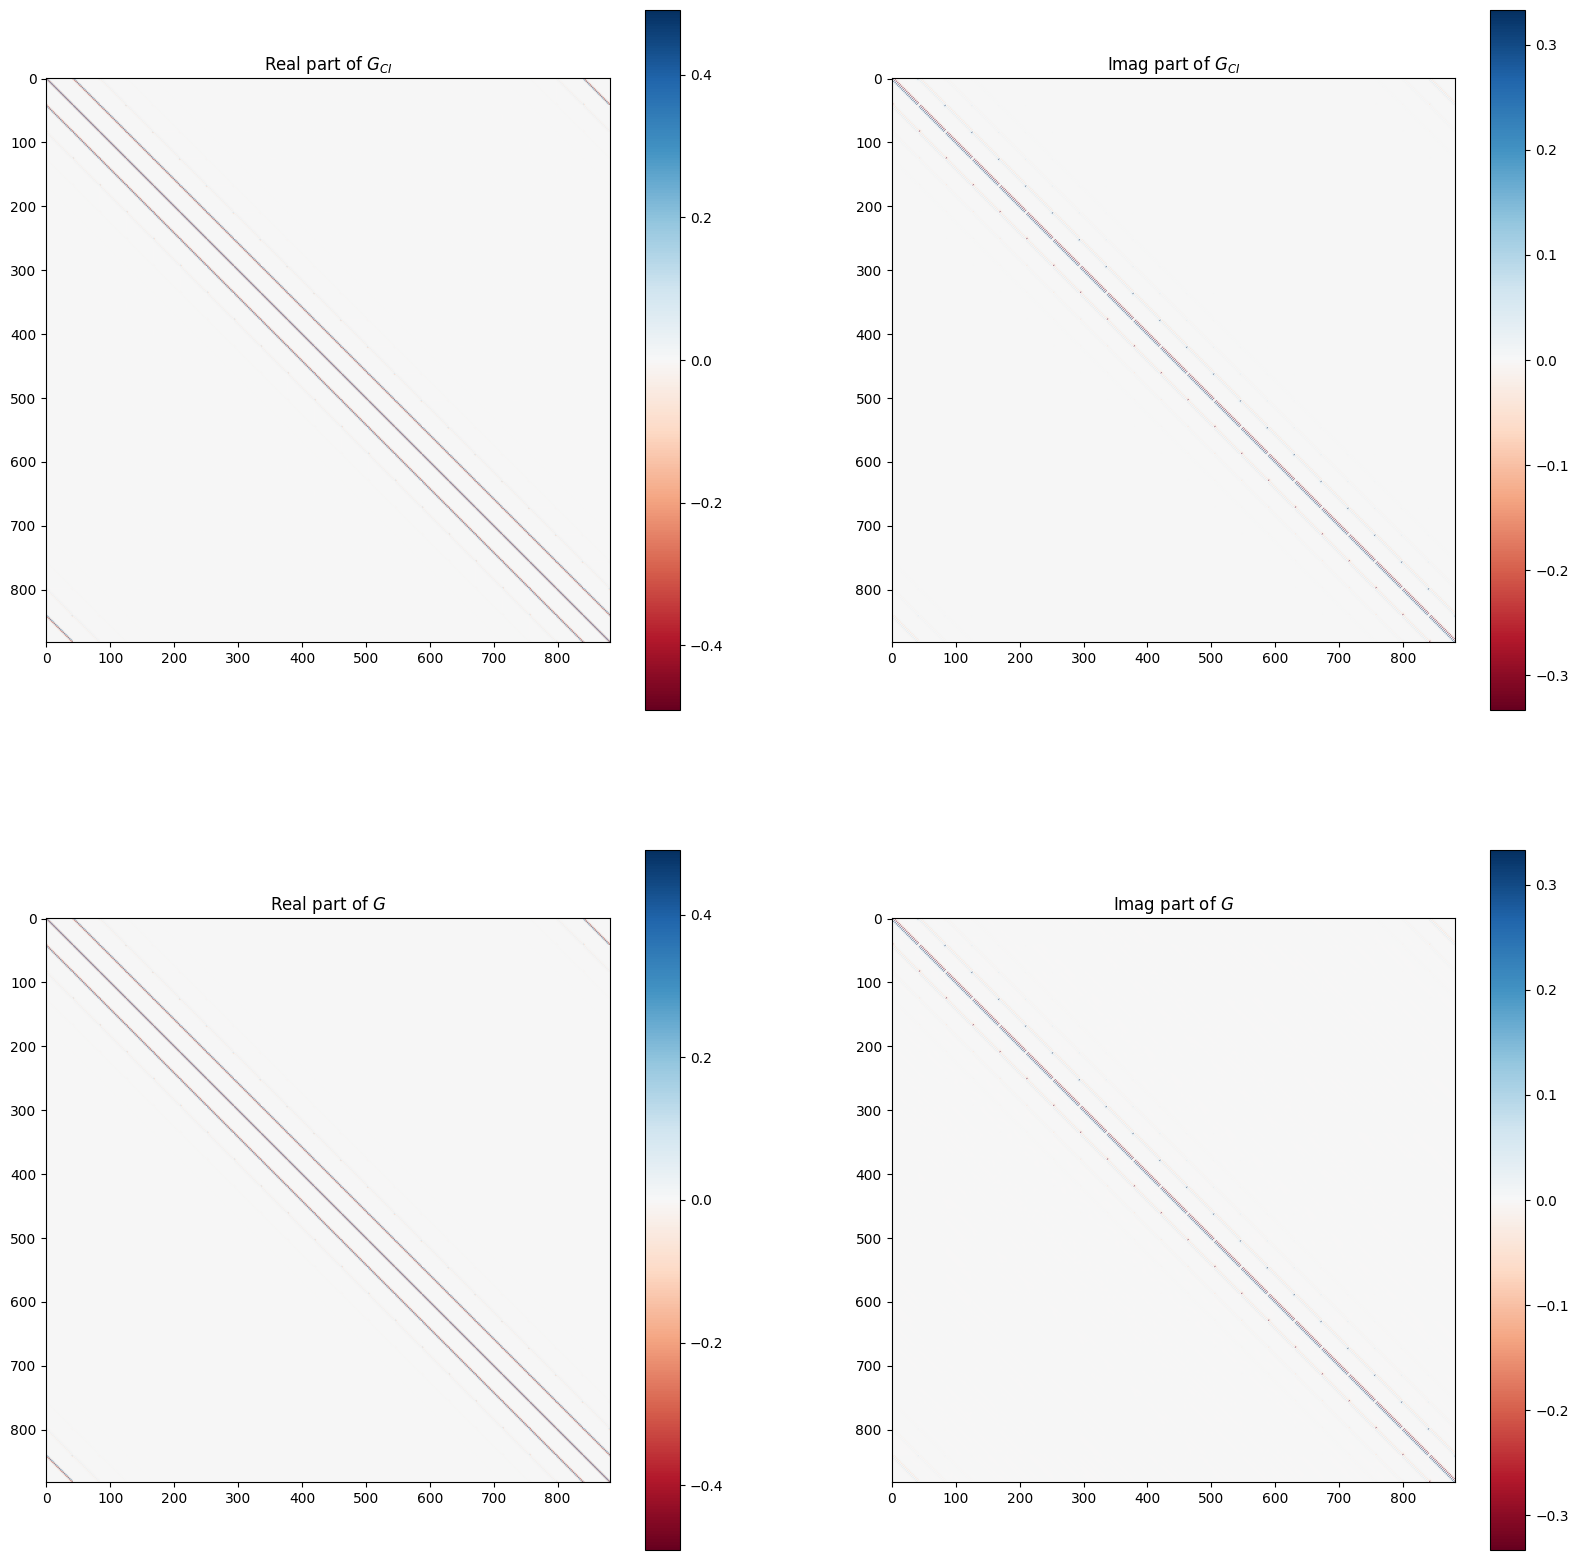

<Figure size 640x480 with 0 Axes>

In [50]:

# Compute covariance matrix
G_CI = m.G_CI()

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# Real part
im0 = axes[0,0].imshow(G_CI.real, cmap='RdBu')
axes[0,0].set_title(r"Real part of $G_{CI}$")
fig.colorbar(im0, ax=axes[0,0])

# Imag part
im1 = axes[0,1].imshow(G_CI.imag, cmap='RdBu')
axes[0,1].set_title(r"Imag part of $G_{CI}$")
fig.colorbar(im1, ax=axes[0,1])

# Real part
im0 = axes[1,0].imshow(Gtt_last.real, cmap='RdBu')
axes[1,0].set_title(r"Real part of $G$")
fig.colorbar(im0, ax=axes[1,0])

# Imag part
im1 = axes[1,1].imshow(Gtt_last.imag, cmap='RdBu')
axes[1,1].set_title(r"Imag part of $G$")
fig.colorbar(im1, ax=axes[1,1])

plt.show()
plt.tight_layout()

In [13]:
import numpy as np
import matplotlib.pyplot as plt

counts = [1, 100, 500, 1000, 5000, 10000]
path = "cache/G_history_samples/N8x8_C20_S10000_nshNone_DW1_init-default_n_a0.5_markov_circuit_alpha_triv=30.npz"

data = np.load(path, allow_pickle=True)
G_hist = data[data.files[0]]  # shape (500, 21, 512, 512)
print(G_hist.shape, G_hist.dtype)

(10000, 21, 128, 128) complex128


In [14]:


Nx = Ny = 8
Nlayer = 2 * Nx * Ny

G_final = G_hist[:, -1, :Nlayer, :Nlayer]

shift_vals, offdiag_vals = [], []

for count in counts:
    G_mean_flat = G_final[:count].mean(axis=0)
    G6 = unflatten_to_G6(G_mean_flat, Nx, Ny)
    report = check_y_translation_invariance(G6, hermitize=True)

    shift_vals.append(report["shift_max_abs_diff"])
    offdiag_vals.append(report["offdiag_ratio"])

    print(
        f"N={count:3d} → "
        f"shift_max_abs_diff={report['shift_max_abs_diff']:.3e}, "
        f"offdiag_ratio={report['offdiag_ratio']:.3e}"
    )


N=  1 → shift_max_abs_diff=1.565e+00, offdiag_ratio=1.411e-01
N=100 → shift_max_abs_diff=1.231e-01, offdiag_ratio=3.583e-03
N=500 → shift_max_abs_diff=1.161e-01, offdiag_ratio=2.237e-03
N=1000 → shift_max_abs_diff=1.177e-01, offdiag_ratio=2.036e-03
N=5000 → shift_max_abs_diff=1.151e-01, offdiag_ratio=1.840e-03
N=10000 → shift_max_abs_diff=1.151e-01, offdiag_ratio=1.836e-03


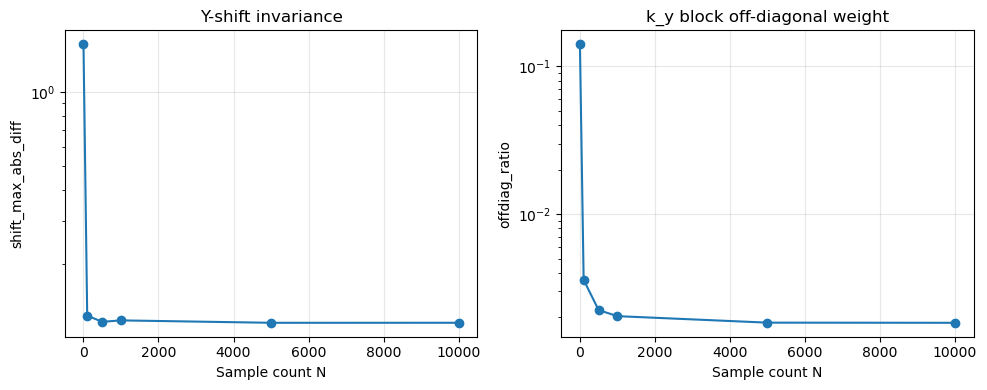

In [15]:

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

axes[0].plot(counts, shift_vals, marker="o")
axes[0].set_yscale("log")
axes[0].set_xlabel("Sample count N")
axes[0].set_ylabel("shift_max_abs_diff")
axes[0].set_title("Y-shift invariance")
axes[0].grid(alpha=0.3)

axes[1].plot(counts, offdiag_vals, marker="o")
axes[1].set_yscale("log")
axes[1].set_xlabel("Sample count N")
axes[1].set_ylabel("offdiag_ratio")
axes[1].set_title("k_y block off-diagonal weight")
axes[1].grid(alpha=0.3)

fig.tight_layout()


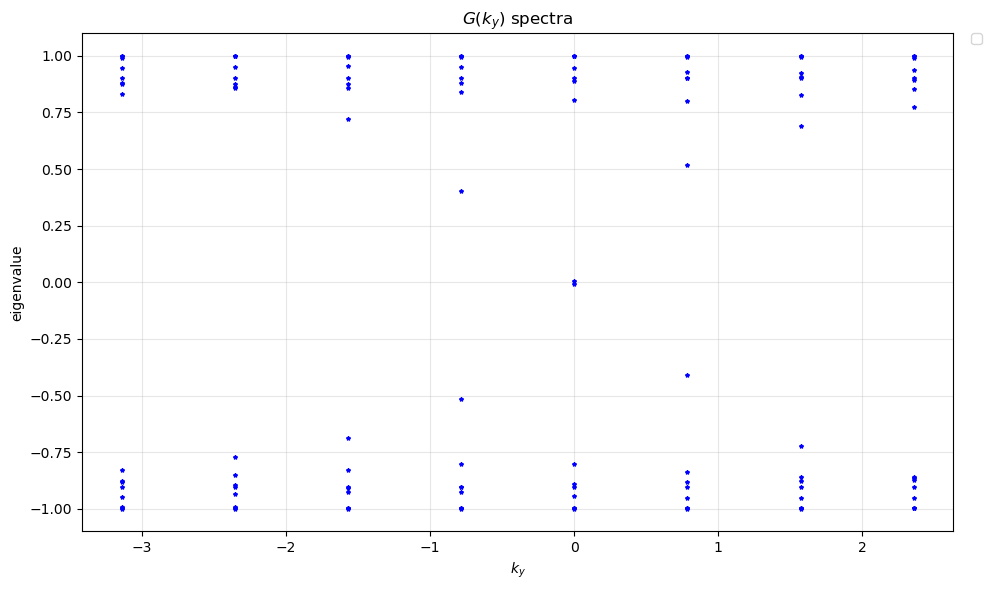

In [20]:
# --- Call the plotting function ---
fig, ax = plt.subplots(figsize=(10,6))

# Decoherence off: blue '*'
ky_off, evals, _ = plot_ky_spectrum(unflatten_to_G6(G_final.mean(axis=0), Nx, Ny), ax=ax, marker='*', ms=3)
# recolor all lines orange
for line in ax.get_lines()[-evals.shape[1]:]:
    line.set_color('blue')

# De-duplicate legend entries and move outside axis
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(),
          loc='upper left', bbox_to_anchor=(1.02,1.0), borderaxespad=0)

ax.set_title("$G(k_y)$ spectra")
ax.set_yscale('linear')
plt.tight_layout()
plt.show()